# How Not To Train Your VAE

![transition](vae_transition_2.png)

Code for 

M. Rivera, How to train your VAE, ICIP 2024.

**By**

Mariano Rivera, version 1.0.0, june 2024

MIT Licence

**Inspired in** 

* The example Tesorflow.Keras VAE  [F. Chollet, Convolutional Variational AutoEncoder (VAE) trained on MNIST digits](https://keras.io/examples/generative/vae/), created 2020/05/03, last version 2020/05/03.

* Example in Chap 3 in [D. Foster, Generative deep learning, OReilly, 2019](https://www.oreilly.com/library/view/generative-deep-learning/9781492041931/)
___________________


## Import libraries

In [3]:
import os
os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"
os.environ["TF_ENABLE_ONEDNN_OPTS"]="0"

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import layers
import os
from glob import glob

## Load CelebA-HQ Dataset

[Celeb_a_hq Male/Female](https://www.kaggle.com/lamsimon/celebahq?select=celeba_hq)

Lui et al., 2015) Z. Lui et al. Deep Learning Face Attributes in the Wild, Proc ICCV 2015.


In [6]:
# run params
DATA_FOLDER   = "/home/mariano/Data/CelebAMask-HQ/CelebA-HQ-img/"   # solitario
DIR_RESULTS   = './results'
PATH_RESULTS  = os.path.join(os.path.abspath('.'),DIR_RESULTS)
INPUT_DIM     = (256,256,3)
BATCH_SIZE    = 10
EPOCHS        = 200
LATENT_DIM    = 512
R_LOSS_FACTOR = 5000
INITIAL_EPOCH = 0

filenames  = np.array(glob(os.path.join(DATA_FOLDER, '*.jpg')))

In [7]:
n_images        = filenames.shape[0]
steps_per_epoch = n_images//BATCH_SIZE
print('num image files : ', n_images)
print('steps per epoch : ', steps_per_epoch )

num image files :  30000
steps per epoch :  3000


**The datasets**

In [29]:
AUTOTUNE = tf.data.AUTOTUNE
dataset=keras.utils.image_dataset_from_directory(directory  = DATA_FOLDER, 
                                                    labels     = None, 
                                                    batch_size = BATCH_SIZE, 
                                                    image_size = INPUT_DIM[:2],
                                                    shuffle    = True,
                                                    validation_split = 0.2,
                                                    subset     = "training",
                                                    seed       = 1967,).repeat()

dataset_val=keras.utils.image_dataset_from_directory(directory  = DATA_FOLDER, 
                                                    labels     = None, 
                                                    batch_size = BATCH_SIZE, #*10, 
                                                    image_size = INPUT_DIM[:2],
                                                    shuffle    = True,
                                                    validation_split = 0.2,
                                                    subset     = "validation",
                                                    seed       = 1967,).repeat()

Found 30000 files.
Using 24000 files for training.
Found 30000 files.
Using 6000 files for validation.


In [9]:
dataset = dataset.prefetch(buffer_size=AUTOTUNE)

data_augmentation = keras.Sequential([
                                layers.RandomFlip    ("horizontal"),
                                layers.Rescaling     (scale=1./127.5, offset=-1),
                                ])
dataset = dataset.map(lambda x: (data_augmentation(x)), num_parallel_calls=AUTOTUNE)

In [10]:
scaling = layers.Rescaling (scale=1./127.5, offset=-1)
dataset_val = dataset_val.map(lambda x: (scaling(x)), num_parallel_calls=AUTOTUNE)

Show some images

In [11]:
X = []
for x in dataset_val.take(1):
    X.append(x) 
    
Images_val = np.array(X)[0]

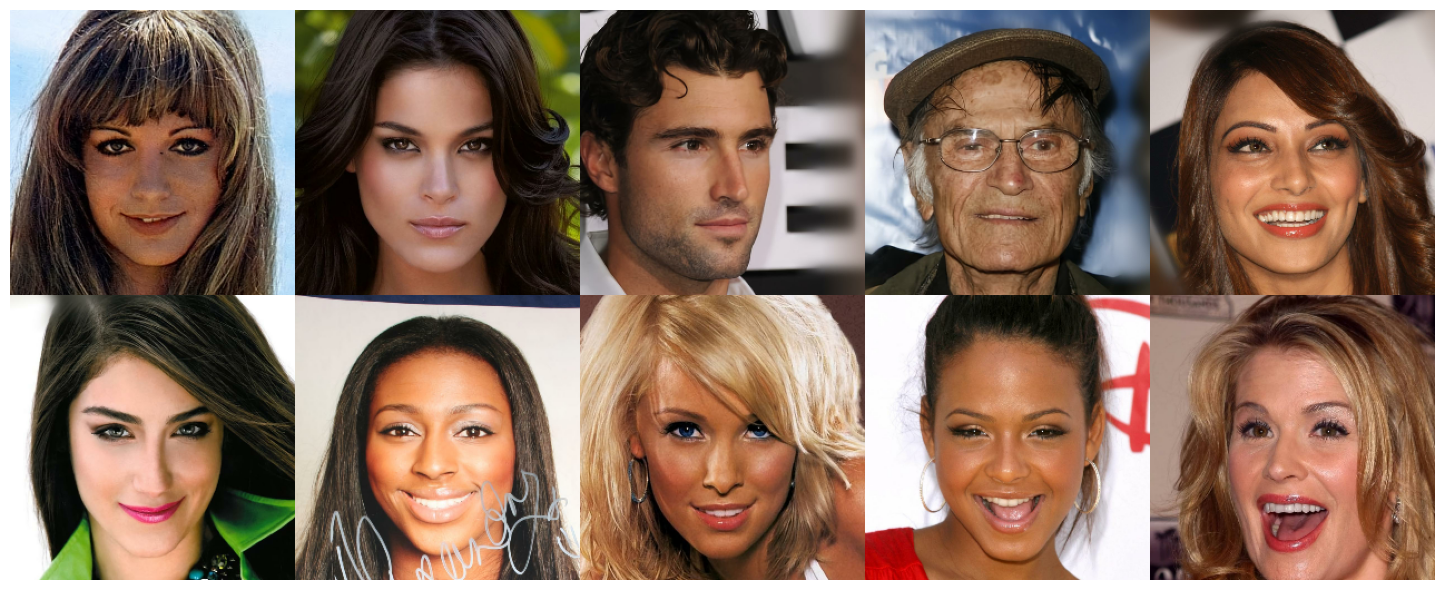

10 256 256 3


In [12]:
from show_warps import show_many

num_img_rows, num_img_cols= 2,5
show_many(Images_val, m=num_img_rows, n=num_img_cols)

numImg, nrows, ncols, nchannels = np.array(Images_val).shape
print(numImg,nrows, ncols, nchannels)

## Models

In [13]:
import keras
import keras.layers as layers
from keras.layers import Dense, Conv2D, Conv2DTranspose, Flatten, Reshape
from keras.layers import Dropout, BatchNormalization, Activation, LeakyReLU
from keras.models import Model, Sequential

from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution

from reader import ResEncoder, ResDecoder, Sampler

**VAE**

In [14]:
from vae import VAE

## TRAINING

In [15]:
class VAE_trainer(keras.Model):
    def __init__(self, r_loss_factor=1, summary=False, **kwargs):
        super().__init__(**kwargs)

        # Architecture
        self.input_dim                 = INPUT_DIM
        self.latent_dim                = LATENT_DIM
        self.use_batch_norm            = True
        self.use_dropout               = True
        self.r_loss_factor             = r_loss_factor

        # Encoder parameters
        self.encoder_conv_filters      = [128, 128, 128, 128, 128, 128, 128]
        self.encoder_conv_kernel_size  = [  3,   3,   3,   3,   3,   3, 3]
        self.encoder_conv_strides      = [  2,   2,   2,   2,   2,   2, 2]            
        # Decoder parameters
        self.decoder_conv_t_filters    = [128, 128, 128, 128, 128,  128, 3]
        self.decoder_conv_t_kernel_size= [  3,   3,   3,   3,   3,    3, 3]
        self.decoder_conv_t_strides    = [  2,   2,   2,   2,   2,   3, 2]

        # Metrics to track
        self.gen_loss_tracker = keras.metrics.Mean(name="gen_loss")
        self.rc_loss_tracker  = keras.metrics.Mean(name="r_loss")
        self.kl_loss_tracker  = keras.metrics.Mean(name="kl_loss")
        self.mae              = keras.losses.MeanAbsoluteError()
        self.log              = tf.math.log
        
        # VAE
        self.vae_model = VAE(input_dim                 = self.input_dim,
                             latent_dim                = self.latent_dim,
                             encoder_conv_filters      = self.encoder_conv_filters, 
                             encoder_conv_kernel_size  = self.encoder_conv_kernel_size, 
                             encoder_conv_strides      = self.encoder_conv_strides, 
                             decoder_conv_t_filters    = self.decoder_conv_t_filters,
                             decoder_conv_t_kernel_size= self.decoder_conv_t_kernel_size, 
                             decoder_conv_t_strides    = self.decoder_conv_t_strides, 
                             r_loss_factor             = self.r_loss_factor,
                             summary                   = summary,
                            )
                
        self.built = True

    def get_config(self):
        config = super().get_config()
        config.update({"units": self.units})
        return config
        
    @property
    def metrics(self):
        return [self.gen_loss_tracker,
                self.kl_loss_tracker,
                ]
        
    @tf.function
    def train_step(self, data):
        '''
        '''
        with tf.GradientTape() as gen_tape:
            
            # generate fakes
            data_hat, z, z_mean, z_log_var = self.vae_model(data)  
            # reconstruction loss
            rec_loss = self.r_loss_factor * self.mae(data, data_hat)
            # KL original loss 
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            # elbo
            gen_loss =  rec_loss + kl_loss

        # train step
        gen_grads = gen_tape.gradient(gen_loss, self.vae_model.trainable_weights)        
        self.generator_optimizer.apply_gradients(zip(gen_grads, self.vae_model.trainable_weights))
        
        # compute progress        
        self.gen_loss_tracker.update_state(gen_loss)
        self.rc_loss_tracker.update_state(rec_loss)     
        self.kl_loss_tracker.update_state(kl_loss)
                
        return {"gen_loss"    : self.gen_loss_tracker.result(),
                "rc_loss"     : self.rc_loss_tracker.result(),
                "kl_loss"     : self.kl_loss_tracker.result(),
                }

    @tf.function
    def generate(self, z_sample):
        '''
        We use the sample of the N(0,I) directly as  
        input of the deterministic generator. 
        '''
        return self.vae.generate(z_sample)

    @tf.function
    def codify(self, images):
        '''
        For an input image we obtain its particular distribution:
        its mean, its variance (unvertaintly) and a sample z of such distribution.
        '''
        x = self.vae.encoder_model.predict(images)
        z, z_mean, z_log_var= self.vae.sampler_model(x)
        return z, z_mean, z_log_var
    
    @tf.function
    def call(self, inputs, training=False):
        '''
        '''
        data_hat,_,_,_ = self.vae_model(inputs, training)
        return data_hat

### Compile

In [16]:
vae = VAE_trainer(r_loss_factor=R_LOSS_FACTOR, summary=True)
vae.summary()

Model: "vae_trainer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ vae (VAE)                       │ ?                         │  9,932,466 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 9,932,466 (37.89 MB)

 Trainable params: 9,908,140 (37.80 MB)

 Non-trainable params: 24,326 (95.02 KB)

In [31]:
file_weights = "model_weights/vae_model_200-680.weights.h5"
vae.load_weights(file_weights)

In [23]:
vae.generator_optimizer     = keras.optimizers.Adam(1e-4, beta_1=0.5)
vae.compile()

In [24]:
file_weights = "model_weights/vae_model_200-680.weights.h5"
vae.load_weights(file_weights)

## Fit

In [20]:
# Uncomment only if your want to train the VAE

"""
BATCH_SIZE    = 20
EPOCHS        = 50
INITIAL_EPOCH = 100

history=vae.fit(dataset,
                batch_size      = BATCH_SIZE,
                epochs          = EPOCHS+INITIAL_EPOCH,
                initial_epoch   = INITIAL_EPOCH,
                steps_per_epoch = steps_per_epoch,)

file_weights = os.path.join(PATH_RESULTS,"vae_gan_model_300-511.weights.h5")
vae_gan.save_weights(file_weights)
""";



## Results

$$
{\bf z}_i^\prime = {\bf z}_i + e_k \epsilon,
$$

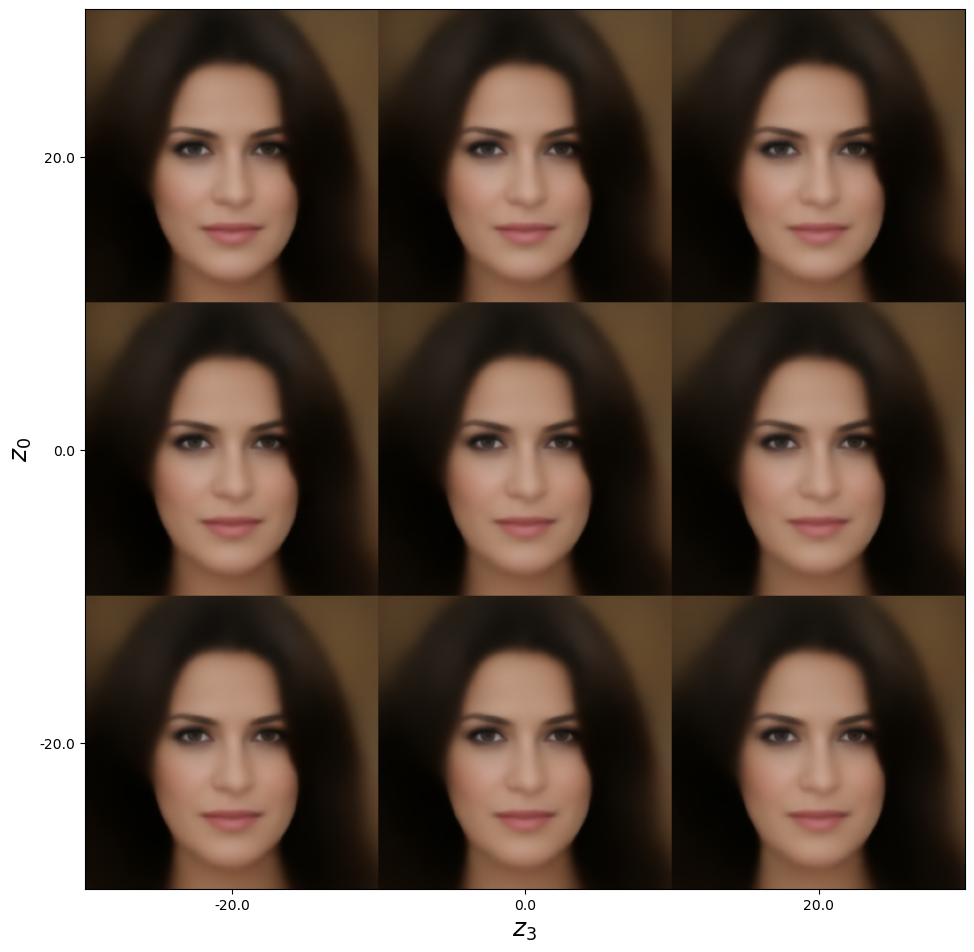

In [25]:
from show_warps import plot_latent_space

plot_latent_space(model=vae.vae_model, image=Images_val[2,:,:,:], n=3,scale=20,latents_start=[0,3])

If fancy faces appeared, ther is a bug in the *model.weights* loader, reload the weights, compile and reload. 

## Convex Combinations of Latent Variables

$$
{\bf z}_k^\prime = (1-\alpha_k) \, {\bf z}_1 + \alpha_k \,{\bf z}_2,
$$

with $\alpha_k = k / (n-1)$; for  $k=0,1,\ldots,5$.

In [26]:
from show_warps import plot_warping

In [27]:
_, _,z1,_ = vae.vae_model(np.expand_dims(Images_val[2,:,:,:], axis=0))  
_, _,z2,_ = vae.vae_model(np.expand_dims(Images_val[5,:,:,:], axis=0))

_, _,z3,_ = vae.vae_model(np.expand_dims(Images_val[1,:,:,:], axis=0))  
_, _,z4,_ = vae.vae_model(np.expand_dims(Images_val[8,:,:,:], axis=0))

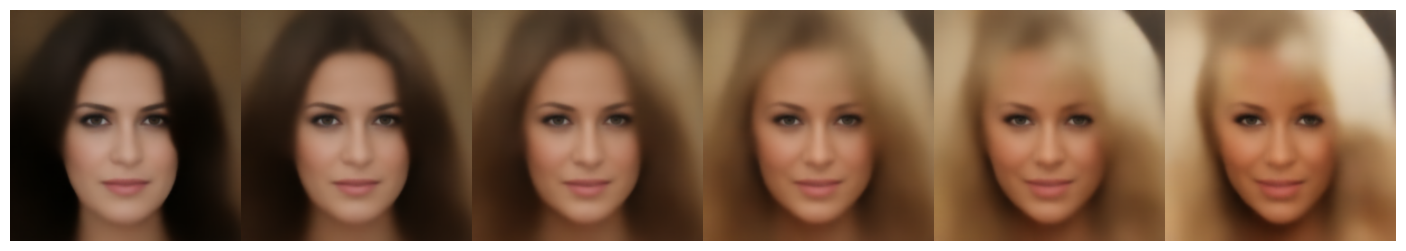

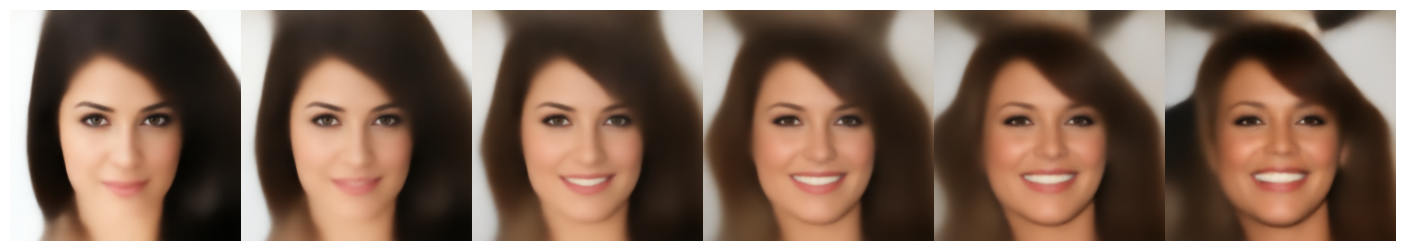

In [28]:
plot_warping(model=vae.vae_model, z1=z1 , z2=z2, n=6)
plot_warping(model=vae.vae_model, z1=z3 , z2=z4, n=6, save_plot=False)